# Use: Tests of `BenamouBrenier.py`

In [111]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from warnings import warn
from tqdm.notebook import tqdm,trange # to display loading bars
%load_ext autoreload
%autoreload 2

from BenamouBrenier import TransportProblem
from transport import gaussian_transport, gaussian_discreatization, random_gaussian_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TransportProblem object initialized.


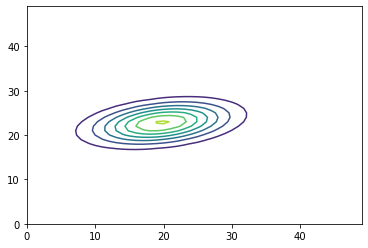

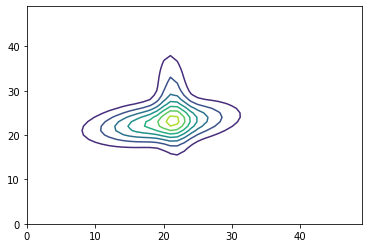

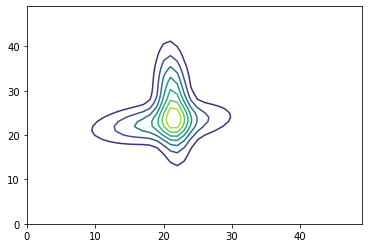

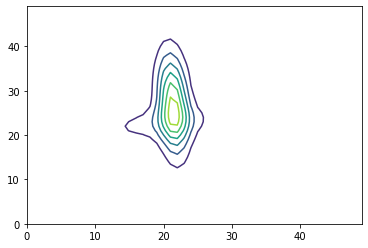

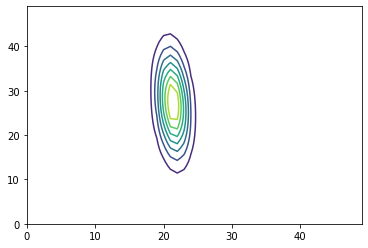

  0%|          | 0/125000 [00:00<?, ?it/s]

Projection step converged to tolerance.
Dual step done.


In [112]:
rng = np.random.default_rng(123)
from scipy.stats import multivariate_normal
N=50
T=50
mesh= np.array(np.meshgrid(np.linspace(-5,5,N),np.linspace(-5,5,N)))

mean1, cov1 = random_gaussian_parameters(2,rng)
mean2, cov2 = random_gaussian_parameters(2,rng)

mu,nu = np.empty((N,N)),np.empty((N,N))
for idx in np.ndindex((N,N)):
    mu[idx] = multivariate_normal.pdf(mesh[(...,*idx)], mean1, cov1)
    nu[idx] = multivariate_normal.pdf(mesh[(...,*idx)], mean2, cov2)

prob1 = TransportProblem(mesh,mu,nu,T)
for i in np.linspace(0,N-1,5).astype(int):
    prob1.plot(i)
prob1.projection_step()
prob1.dual_step()

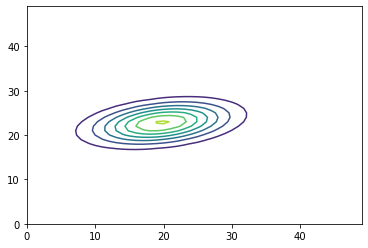

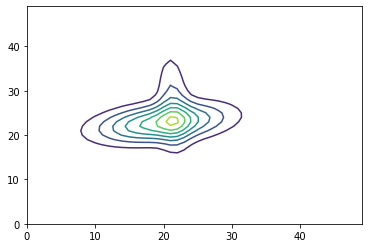

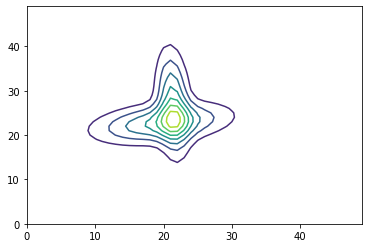

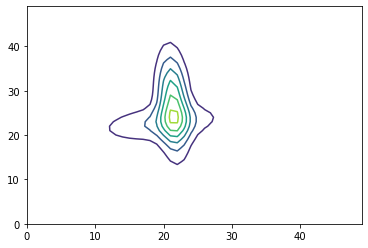

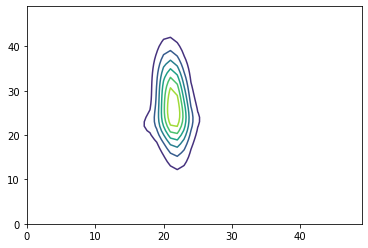

In [113]:
for i in range(0,N,10):
    prob1.plot(i)

## Todo
- check if code works for 1D ndarray with/without empty dimensions
- Use a package to compute poisson equation

## Remarks
- **Projection Step**:
    - Analytic solution complicated and numerically instable. reduce the problem to 1D (grid-wise), and use Newton method to solve the polynomial equation of orthogonality. [Algorithms for projecting points onto conics](https://www.sciencedirect.com/science/article/pii/S0377042713001398#s000005)
    - choice of the initial point ([desmos graphic](https://www.desmos.com/calculator/nj6gcjfbaq)) to get the right zero.
- **Dual Step**: easy
- **Poisson Step**:
    - first order condition by calculus of variations, how to do it, and leads to weak poisson equation.
    - border conditions
    - https://fenicsproject.org can solve poisson equation, see [demo_poisson](https://docs.fenicsproject.org/dolfinx/v0.6.0/python/demos/demo_poisson.html)
- What is the Domain $\Omega\subset\mathbb{R}^d$, should contain the support of $\mu$ and $\nu$?
- gaussian transport
    - restrict to an ellipsis support of $\mu$ and renormalise (polar coord and 1D normal distribution)
    - the transport map is still optimal and lead to an ellipsis support, and is still optimal.